# Across-Sessions Within Subject Testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we explore how to implement the Across-sessions-test-within subjects using the [GLHMM toolbox](https://github.com/vidaurre/glhmm), part of the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://arxiv.org/abs/2312.07151). This test is ideal for studying variability across different sessions, making it particularly suited for longitudinal studies involving multiple scanning sessions.

In real-world applications, one would typically fit a Hidden Markov Model (HMM) to actual data. However, for demonstration purposes, we use [synthetic data](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) for both the brain data ($D$) and the behavioural variable ($R$) in the ```across_sessions_within_subject``` test.

The synthetic data is generated using the toolbox [Genephys](https://github.com/vidaurre/genephys), developed by [Vidaurre in 2023](https://elifesciences.org/reviewed-preprints/87729). Genephys enables the simulation of electrophysiological data in psychometric experiments, creating scenarios where a subject is exposed to various stimuli while EEG or MEG data is recorded.

For this tutorial:

* The simulated brain data ($D$) consists of EEG or MEG recordings with 16 channels, measured across multiple trials and sessions. Each trial consists of 250 timepoints.
* The behavioural data ($R$) is continuous and represents reaction times for individual trials.

While data preparation requires some explanation, running the ```across_sessions_within_subject``` test is straightforward. Simply provide the input variables ($D$ and $R$) and specify the method for the analysis.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_sessions_within_subject.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Load and prepare data](#load-data)
    * [Look at data](#look-data)
    * [Prepare data for HMM](#prep_hmm)
2. [Load data or initialise and train HMM](#load_hmm)
    * [Data restructuring](#data-recon)
3. [Across-sessions within subject testing](#across_sessions)
    * [Across-sessions within subject testing - Multivariate](#perm-regression)
    * [Across-sessions within subject testing - Univariate](#perm-correlation)
    * [Across-trials - Multivariate](#perm-regression-trial)

### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [9]:
import numpy as np
from pathlib import Path
from glhmm import glhmm, graphics, statistics,preproc

## 1. Load and prepare data <a id="load-data"></a>
First, we'll load the synthetic data from this [folder](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [glhmm toolbox](https://github.com/vidaurre/glhmm) to train a classic HMM on the synthetic data that represents EEG or MEG measurements.\
Let's start by loading the essential data for this tutorial:

In [10]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"

# Load D data
D_sessions = np.load(PATH_DATA/"D_sessions.npy")
# Load R data
R_sessions = np.load(PATH_DATA/"R_sessions.npy")
# Load indices
idx_sessions = np.load(PATH_DATA/"idx_sessions.npy")

print(f"Data dimension of D-session data: {D_sessions.shape}")
print(f"Data dimension of R-session data: {R_sessions.shape}")
print(f"Data dimension of indices: {idx_sessions.shape}")

Data dimension of D-session data: (250, 1500, 16)
Data dimension of R-session data: (1500,)
Data dimension of indices: (10, 2)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- D_sessions: 3D array of shape (n_timepoints, n_trials, n_features)
- R_sessions: 3D array of shape (n_trials,)
- idx_sessions: 2D array of shape (n_sessions, 2)

```D_sessions``` represents the data collected from the subject, structured as a list with three elements: ```[250, 1500, 16]```. The first element indicates that the subject underwent measurement across ```250``` timepoints. The second element, ```1500```, corresponds to the total number of trials conducted. In this context, 10 distinct sessions were executed, each comprising 150 trials, lead up to a total of 1500 trials (150*10). Each individual trial involved the measurement of ```16``` channels within the EEG or MEG scanner.

```R_sessions``` simulates the measured reaction time for each trial that the subject undergoes at different sessions. 

Lastly, we have ```idx_sessions = [10, 2]```. This indicates the number of sessions conducted, which in this case is ```10```. The values in each row represent the start and end indices of the trials.



### Prepare data for HMM <a id="prep_hmm"></a>
When you're getting into training a Hidden Markov Model (HMM), the input data needs to follow a certain setup. The data shape should look like ((number of timepoints * number of trials), number of features). This means you've lined up all the trials from different sessions side by side in one long row. The second dimension is the number of features, which could be the number of parcels or channels. 

So, in our scenario, we've got this data matrix, ```D_session```, shaped like ```[250, 1500, 16]``` (timepoints, trials, channels). Now, when we bring all those trials together, it's like stacking them up to create a new design matrix, and it ends up with a shape of ```[375000, 16]``` (timepoints * trials, channels). 
Beside that we also need to update ```R_session``` and ```idx_sessions``` to sync up  with the newly concatenated data. To make life easier, we've got the function ```get_concatenate_sessions```. It does the heavy lifting for us.

In [11]:
D_con,R_con,idx_con=statistics.get_concatenate_sessions(D_sessions, R_sessions, idx_sessions)
print(f"Data dimension of the concatenated D-data: {D_con.shape}")
print(f"Data dimension of the concatenated R-data: {R_con.shape}")
print(f"Data dimension of the updated time stamp indices: {idx_con.shape}")

Data dimension of the concatenated D-data: (375000, 16)
Data dimension of the concatenated R-data: (375000,)
Data dimension of the updated time stamp indices: (10, 2)


For a quick sanity check, let's verify whether the concatenation was performed correctly on ```D_sessions```. We've essentially stacked up every timepoint from each trial sequentially.

To do this, we can compare a slice of our original design matrix, say ```D_sessions[:, 0, :]```, with the corresponding slice in the concatenated data, ```D_con[0:250, :]```.\
If the comparison ```D_sessions[:, 0, :] == D_con[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [12]:
np.array_equal(D_sessions[:, 0, :], D_con[0:250, :])

True

Here, it's evident that the concatenation process has been executed accurately.

Next up, let's confirm if the values in ```idx_con``` have been appropriately updated. Each row in this matrix should represent the total count of timepoints and trials for each of the 10 sessions. In our case, it should total to 37500 for each session (calculated as 250 time points * 150 trials). 

In [13]:
# Look at idx_con
idx_con

array([[     0,  37500],
       [ 37500,  75000],
       [ 75000, 112500],
       [112500, 150000],
       [150000, 187500],
       [187500, 225000],
       [225000, 262500],
       [262500, 300000],
       [300000, 337500],
       [337500, 375000]])

Indeed, each session now aligns with ```37500``` datapoints. This means that when we pooled together the timepoints and trials, the count for each session ended up exactly as expected. It's a reassuring confirmation that our concatenation didn't miss a beat.

**Please take note: If the measurements haven't been continuously recorded within a single session but have been pre-processed and exported on a trial-by-trial basis, we'll need to construct the indices in a different manner. In our case, where we have 250 timepoints for each trial, where each trial consists of 250 timepoints and there are a total of 1500 trials, the indices must be created by specifying the start and end timepoints for each trial.**

You can create these indices using the ```get_timestamp_indices``` function. The following example will guide you through the process.


In [14]:
idx_trials =statistics.get_indices_timestamp(D_sessions.shape[0], D_sessions.shape[1])
print(f"Values in index:\n{idx_trials}\n")
print(f"Shape of index: {idx_trials.shape}")

Values in index:
[[     0    250]
 [   250    500]
 [   500    750]
 ...
 [374250 374500]
 [374500 374750]
 [374750 375000]]

Shape of index: (1500, 2)


**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much).

In [15]:
D_con_preproc,_ = preproc.preprocess_data(D_con, 
                                          idx_trials)

## 2. Load data or initialise and train HMM <a id="load_hmm"></a>

You can either load the `Gamma` values from a pretrained model or train your own model. If you prefer the former option, load the `Gamma_sessions` from the [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder. The GLHMM model in question has been trained utilizing a Gaussian observation model, incorporating mean and covariance parameters for 6 distinct states.\
However, if you would rather train your own model, you can use the variables ```D_con``` and ```idx_con``` as inputs and and complete this section.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'``` and the number of states to ```K=6```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.

In [16]:
# Create an instance of the glhmm class
K = 6 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 6, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True,  True])}


**Train an HMM**\
Now, let's proceed to train the HMM using the loaded data (```D_con```) and time indices (```idx_con```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```D_con```), and indices should encompass the beginning and end indices of each subject (```idx_con```).

If you want to use the same Gamma values as used in this tutorial without training the HMM, you can just load ```Gamma``` using the code below:

```python
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"
# Load Gamma data
Gamma = np.load(PATH_DATA/"Gamma_sessions.npy")
print(f"Data dimension of Gamma: {Gamma.shape}")

```


In [10]:
Gamma,Xi,FE = hmm.train(X=None, 
                        Y=D_con_preproc.astype(np.float64), 
                        indices=idx_trials)

Init repetition 1 free energy = 10424285.62136018
Init repetition 2 free energy = 10424471.457711864
Init repetition 3 free energy = 10418736.098348387
Init repetition 4 free energy = 10416991.333350975
Init repetition 5 free energy = 10413512.681879953
Best repetition: 5
Cycle 1 free energy = 10415552.22543761
Cycle 2 free energy = 10404433.474428767
Cycle 3, free energy = 10399962.798963035, relative change = 0.286776134646397
Cycle 4, free energy = 10396844.666747313, relative change = 0.16667766582172433
Cycle 5, free energy = 10394446.060602685, relative change = 0.11364481247008078
Cycle 6, free energy = 10392542.188508492, relative change = 0.08274094040171934
Cycle 7, free energy = 10390976.895951219, relative change = 0.06369365497784654
Cycle 8, free energy = 10389665.812333891, relative change = 0.05064755831851465
Cycle 9, free energy = 10388570.153590763, relative change = 0.04060691667219894
Cycle 10, free energy = 10387666.949602965, relative change = 0.03238999653987988

As you can see, the datapoints in Gamma correspond to the concatenated data (```375000```), and the number of columns represent the six different states.

In [18]:
Gamma.shape

(375000, 6)

### Data restructuring <a id="data-recon"></a>
Now we have trained our HMM and got our ```Gamma```  values we need to restructure the data back to the original data structure. In this case we are not doing HMM-aggregated statistics, but we will instead perform the statistical testing per time point. 
We will acheive this by applying the function ```reconstruct_concatenated_to_3D```. It takes a concatenated 2D matrix and converts it into a 3D matrix. 
So, it will convert  ```Gamma```, shaped like ```[375000, 6]``` back to the original format for number of time points and trials shaped like ```[250, 1500, 6]``` (timepoints, trials, channels).

In [19]:
# Reconstruct the Gamma matrix 
n_timepoints, n_trials, n_channels = D_sessions.shape[0],D_sessions.shape[1],Gamma.shape[1]
Gamma_epoch =statistics.reconstruct_concatenated_to_3D(Gamma,
                                                       n_timepoints=n_timepoints, 
                                                       n_trials=n_trials, 
                                                       n_channels=n_channels)

As a sanity check we will see if ```gamma_epoch``` is actually structured correctly by comparing it with ```Gamma```.

To do this, we can compare a slice of our 3D-matrix, like ```gamma_epoch[:, 0, :]```, with the corresponding slice in the concatenated 2D-data, ```Gamma[0:250, :]```.\
If the comparison ```gamma_epoch[:, 0, :] == Gamma[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. 



In [20]:
np.array_equal(Gamma_epoch[:, 0, :], Gamma[0:250, :])

True

## 3. Across-sessions within subject testing <a id="across_sessions"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```test_across_sessions_within_subject``` function.
This function helps us to find connections between HMM state occurrences (D) and behavioral variables or individual traits (R) using permutation testing.


**Permutation testing**\
Permutation testing does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any assumptions about the data.
This null distribution becomes our benchmark to test the question: is there any real difference or relationship between the variables we're interested in?

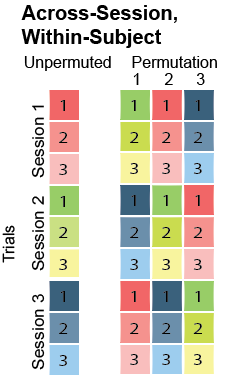

 **Figure 5C** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across sessions. Each number corresponds to a trial within a session and permutations are performed between sessions, with each session containing the same number of trials.


**Hypothesis**
* Null Hypothesis (H0): No significant relationship exists between the independent variables and the dependent variable.
* Alternative Hypothesis (H1):: There is a significant relationship between the independent variables and the dependent variable.



### Across-sessions within subject testing - Multivariate<a id="perm-regression"></a>
The multivariate analysis aims to evaluate whether the state time courses of our brain data ($D$) contribute to explaining the observed variability in behavioral measurements ($R$) like reaction time. By quantifying explained variance, this analysis determines whether state time courses significantly influence changes in behavioral responses.

If there is no difference in brain activity between sessions, it suggests that the brain’s response to the stimuli is consistent over time. However, if we detect differences, this could indicate that the subject's perception of the task changes over time, as reflected by variations in brain activity across sessions.

To run the ```test_across_sessions_within_subject``` test, we set the following parameters:

**Inputs**:

* ```D_data```: The state time courses of the brain data (```Gamma_epoch```).
* ```R_data```: The behavioral measurements (```R_trials```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_trials_session```)

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```test_statistics_option = True```: Ensures the permutation distribution is exported.

Additional settings allow for the inclusion of confounding variables, which can be regressed out during the permutation testing process. For details on these settings, refer to the function documentation.



In [ ]:
# Set the parameters for across sessions within subject testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic = True
# Perform across-subject testing
result_multivariate_session  =statistics.test_across_sessions_within_subject(D_data=Gamma_epoch, 
                                                                             R_data=R_sessions, 
                                                                             idx_data=idx_sessions,
                                                                             method=method,
                                                                             Nperm=Nperm, 
                                                                             test_statistics_option=True)

Maximum number of permutations with 10 sessions is: 3.63e+06
performing permutation testing per timepoint


100%|██████████| 250/250 [01:08<00:00,  3.67it/s]


We can now examine the local ```result_regression_session``` variable.

In [22]:
result_multivariate_session

{'pval': array([0.223, 0.611, 0.849, 0.648, 0.685, 0.862, 0.786, 0.988, 0.372,
        0.487, 0.349, 0.467, 0.187, 0.918, 0.781, 0.711, 0.736, 0.32 ,
        0.462, 0.032, 0.173, 0.594, 0.148, 0.194, 0.704, 0.75 , 0.997,
        0.98 , 0.82 , 0.479, 0.336, 0.095, 0.096, 0.002, 0.088, 0.083,
        0.027, 0.011, 0.004, 0.07 , 0.001, 0.001, 0.004, 0.027, 0.002,
        0.009, 0.003, 0.009, 0.048, 0.016, 0.008, 0.005, 0.004, 0.002,
        0.001, 0.001, 0.004, 0.001, 0.001, 0.001, 0.002, 0.001, 0.002,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.003, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.002, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.002,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001

What we can see here is that ```result_multivariate_session``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [GLHMM paper](https://arxiv.org/abs/2312.07151).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_sessions_within_subject```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

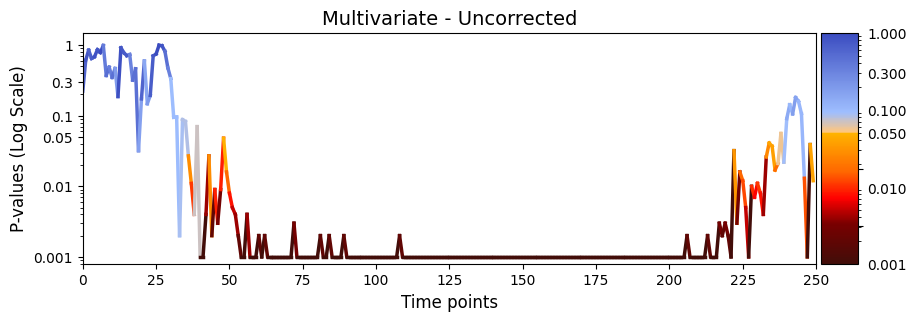

In [ ]:
# The alpha score we set for the p-values
alpha = 0.05
# Plot p-values
graphics.plot_p_values_over_time(result_multivariate_session["pval"], 
                                 title_text ="Multivariate - Uncorrected",
                                 figsize=(10, 3), 
                                 xlabel="Time points", 
                                 alpha=alpha, 
                                 num_x_ticks=11)

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Benjamini/Hochberg correction.

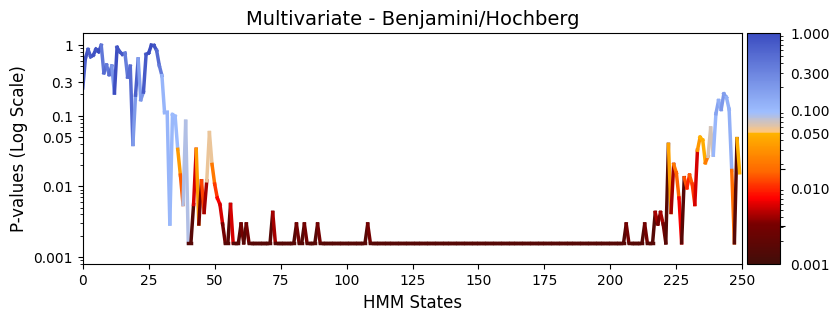

In [ ]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivariate_session["pval"], 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, 
                                 title_text ="Multivariate - Benjamini/Hochberg",
                                 figsize=(9, 3), 
                                 xlabel="HMM States", 
                                 num_x_ticks=11)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.
To use this p-value correction, set ```test_statistics_option=True``` while performing permutation testing, as it is an input to the function (```pval_cluster_based_correction```).

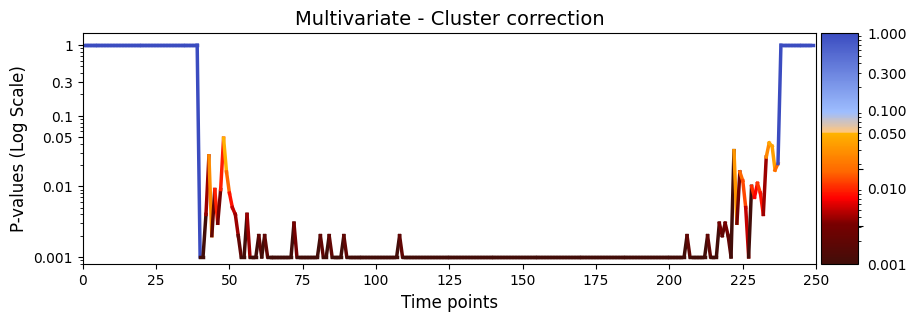

In [ ]:
pval_cluster =statistics.pval_cluster_based_correction(result_multivariate_session["test_statistics"],
                                                       result_multivariate_session["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, 
                                 title_text ="Multivariate - Cluster correction",
                                 figsize=(10, 3), 
                                 xlabel="Time points", 
                                 num_x_ticks=11)

#### Conclusion - Multivariate test
In the permutation testing across sessions, we examined the relationship between state time courses ($D$) and reaction time ($R$) across experimental sessions while preserving trial order. . Using synthetic data, the test identified significant differences from 27 to 230 timepoints. Although this extensive significance is likely due to synthetic data limitations, it highlights the toolbox's effectiveness in detecting across-session differences. In real experiments, such periods could reflect critical cognitive or neural processes depending on the task design.

### Across-sessions within subject testing - Univariate test<a id="perm-correlation"></a>
The univariate analysis examines how each state in the brain's activity ($D$, represented by gamma_epoch) relates to the behavioral measurements ($R$). This method looks for patterns between individual states and the variability in behavioral responses, such as 'reaction time', across sessions.

To run the ```test_across_sessions_within_subject``` test, we set the following parameters:

**Inputs**:

* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The behavioral measurements (```R_sessions```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_sessions```)

**Settings**:

* ```method = "univariate"```: Specifies that the test should perform univariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```test_statistics_option = True```: Ensures the permutation distribution is exported.

Additional settings allow for the inclusion of confounding variables, which can be regressed out during the permutation testing process. For details on these settings, refer to the function documentation.


In [26]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate =statistics.test_across_sessions_within_subject(D_data=Gamma_epoch, 
                                                                  R_data=R_sessions, 
                                                                  idx_data=idx_sessions,
                                                                  method=method,
                                                                  Nperm=Nperm, 
                                                                  test_statistics_option=True)

Maximum number of permutations with 10 sessions is: 3.63e+06
performing permutation testing per timepoint


100%|██████████| 250/250 [07:30<00:00,  1.80s/it]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value matrix.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

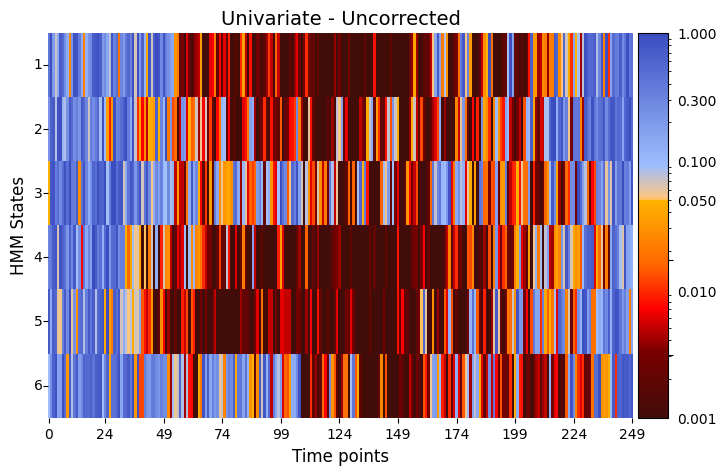

In [ ]:
# Plot p-values
# P-values between reaction time and each state as function of time
graphics.plot_p_value_matrix(result_univariate["pval"].T, 
                             title_text ="Univariate - Uncorrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

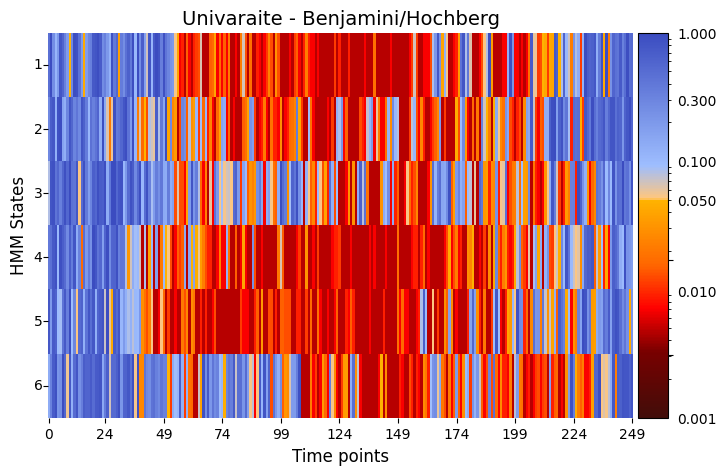

In [ ]:
alpha = 0.05 # threshold for p-values
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], 
                                                               method='fdr_bh', alpha=0.5)
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, 
                             title_text ="Univaraite - Benjamini/Hochberg",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.

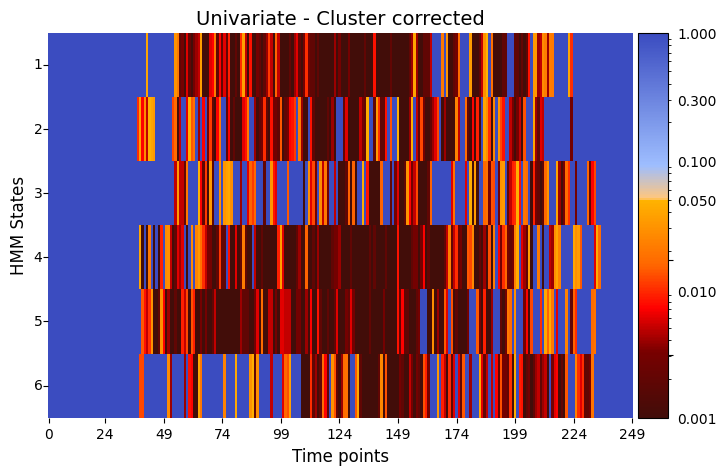

In [ ]:
pval_cluster =statistics.pval_cluster_based_correction(result_univariate["test_statistics"],
                                                       result_univariate["pval"])
# Plot p-values
graphics.plot_p_value_matrix(pval_cluster.T, 
                             title_text ="Univariate - Cluster corrected",
                             figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

**Family-Wise Error Rate (FWER) correction**\
Applying multiple correction directly using FWER

Maximum number of permutations with 10 sessions is: 3.63e+06
performing permutation testing per timepoint


100%|██████████| 250/250 [05:55<00:00,  1.42s/it]


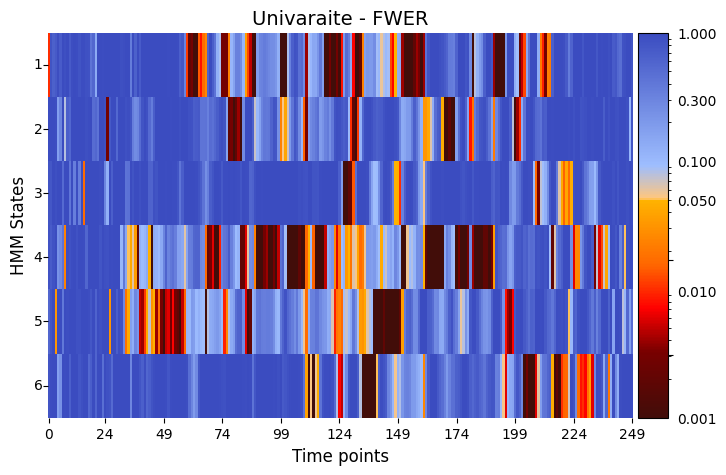

In [30]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate_FWER =statistics.test_across_sessions_within_subject(D_data=Gamma_epoch, 
                                                                       R_data=R_sessions, 
                                                                       idx_data=idx_sessions,
                                                                       method=method,Nperm=Nperm, 
                                                                       test_statistics_option=True,
                                                                       FWER_correction=True)

# Plot p-values
# P-values between reaction time and each state as function of time
graphics.plot_p_value_matrix(result_univariate_FWER["pval"].T, 
                             title_text ="Univaraite - FWER",figsize=(8, 5), 
                             xlabel="Time points", 
                             ylabel="HMM States", 
                             annot=False, 
                             num_x_ticks=11)

#### Conclusion - Univariate
Using synthetic data, the univariate test compared individual states to reaction time in a pairwise manner. After correcting p-values with the Benjamini/Hochberg method, varying degrees of significance were observed for states 1, 2, 3, 5, and 6 during the same timespan as the multivariate test (27 to 230 timepoints), while state 4 showed minimal or no significance.

When Family-Wise Error Rate (FWER) correction using the MaxT method was applied separately to the uncorrected data, it removed many of the initially significant points. This indicates that some of the findings from the Benjamini/Hochberg-corrected results may still include false positives, emphasizing the importance of choosing the appropriate correction method depending on the analysis context.

### Across-trials within session testing - Multivariate <a id="perm-regression-trial"></a>
From our previous result, it is evident that there are variations at specific time windows across multiple sessions. This indicates significant changes occurring during each experimental session in which the subject is involved.

An intriguing aspect of this dataset is the opportunity to delve into trial-by-trial variability within each experimental session. Even though we observe a significant difference across sessions, it's possible that there are specific periods across trials that shows variability. This hypothesis can be tested using the function ```test_across_trials_within_session```.

To run the ```test_test_across_trials_within_session``` test, we set the following parameters:

**Inputs**:

* ```D_data```: The state time courses of the brain data (```gamma_epoch```).
* ```R_data```: The behavioral measurements (```R_trials```).
* ```idx_data``` : Indices for the first and last trial for a given session (```idx_trials_session```)

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```test_statistics_option = True```: Ensures the permutation distribution is exported.

Additional settings allow for the inclusion of confounding variables, which can be regressed out during the permutation testing process. For details on these settings, refer to the function documentation.


In [31]:
# Set the parameters for across trials testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 1000)
test_statistics_option = True

# Perform across-trial testing
result_multivaraite_trials  =statistics.test_across_trials(Gamma_epoch, 
                                                           R_sessions, 
                                                           idx_sessions,
                                                           method=method,
                                                           Nperm=Nperm, 
                                                           test_statistics_option=test_statistics_option)


performing permutation testing per timepoint


100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_p_values_over_time``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

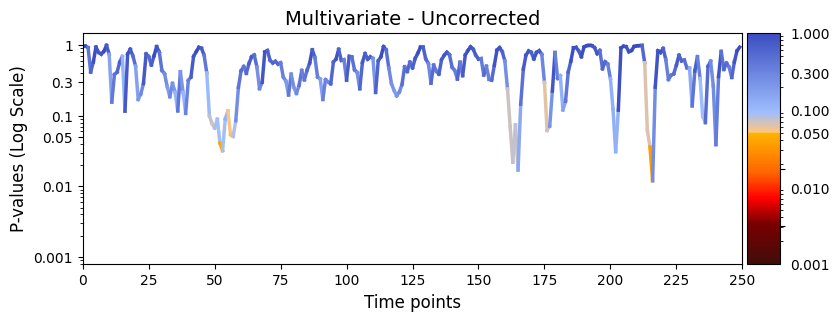

In [32]:
# Plot p-values
graphics.plot_p_values_over_time(result_multivaraite_trials["pval"], 
                                 title_text ="Multivariate - Uncorrected",
                                 figsize=(9, 3), 
                                 xlabel="Time points", 
                                 num_x_ticks=11)

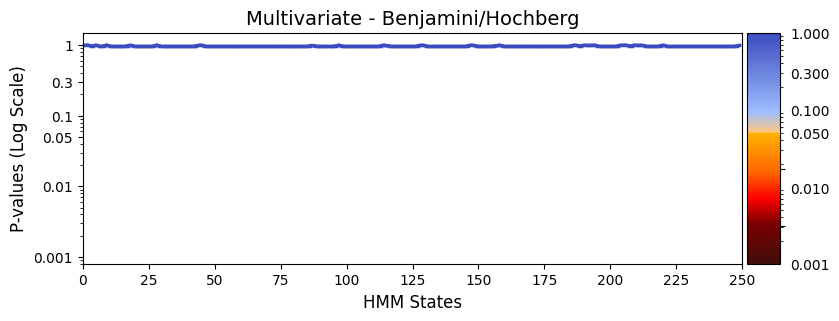

In [35]:
# Multiple correction
alpha = 0.05
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivaraite_trials["pval"], 
                                                               method='fdr_bh',alpha=alpha)
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, 
                                 title_text ="Multivariate - Benjamini/Hochberg",
                                 figsize=(9, 3), 
                                 xlabel="HMM States", 
                                 num_x_ticks=11)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.


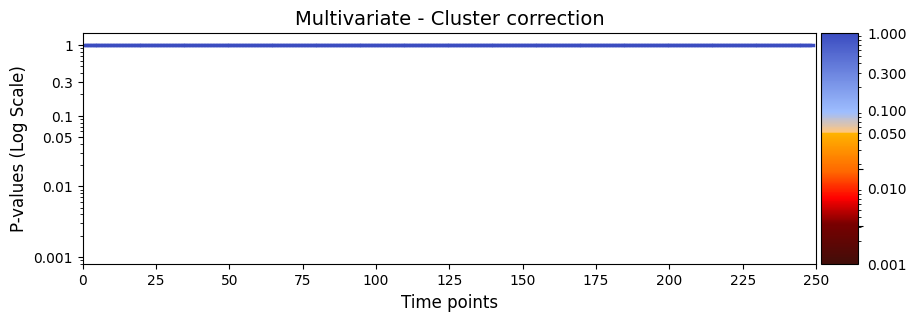

In [34]:
pval_cluster =statistics.pval_cluster_based_correction(result_multivaraite_trials["test_statistics"],
                                                       result_multivaraite_trials["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, 
                                 title_text ="Multivariate - Cluster correction",
                                 figsize=(10, 3), 
                                 xlabel="Time points", 
                                 num_x_ticks=11)

#### Conclusion - Multivariate trials
In the multivariate test across trials, we examined the relationship between state time courses ($D$) and reaction time ($R$) across different trials within experimental sessions.

After correcting the p-values, no significant differences were found across the time points. This suggests a stable relationship between state time courses and reaction time throughout trials within each session. This stability indicates that, within a single session, the subject's performance remains relatively consistent in terms of the observed state time courses and corresponding reaction times.

This finding is consistent with how the synthetic data was generated, where reaction times were designed to remain stable across trials within a session but to vary across sessions. While this tutorial primarily focuses on variability between sessions, incorporating trial-to-trial variability within a session provides a more comprehensive view of the data, offering finer insights into performance dynamics.